# Introduction
After the training is complete, or even after an intermediate checkpoint, it is always useful to visualise the results obtained.

### Imports
Import libraries and write settings here.

## General packages

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model, Sequential
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Input, Dropout, Activation, Conv2D, MaxPooling2D, UpSampling2D, Lambda, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import callbacks, initializers, layers, models, optimizers
from keras import backend as K

from pathlib import Path

/home/luca/anaconda3/envs/cc_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/luca/anaconda3/envs/cc_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/luca/anaconda3/envs/cc_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/luca/anaconda3/envs/cc_env/lib/python3.6/site-

## Custom modules 

In [2]:
repo_path = Path("/home/luca/PycharmProjects/cell_counting_yellow")

import sys
code_path = str(repo_path)
sys.path.append(code_path)

# from config import *
# # import post_processing
# import visualise_results

In [3]:
import visualise_results

# Visualisation
A first step is to have a closer look at the raw output of the model.

In our case, the algorithm predicts a heatmap that attaches to each pixel a number between 0 and 1. This value has to be interpreted as the confidence the model has in classifying that pixel as belonging to a neuronal cell.

In [4]:
# create path to store validation images separately
SAMPLE_IMG_PATH = repo_path / "DATASET/test_tr_opt/sample_valid/images"
SAMPLE_MASKS_PATH = repo_path / "DATASET/test_tr_opt/sample_valid/masks"
# valid_img_path.mkdir(parents=True, exist_ok=True)
# valid_masks_path.mkdir(parents=True, exist_ok=True)

    
### MODEL
model_name = "ResUnetNaa.h5"
model_path = "{}/model_results/{}".format(repo_path, model_name)

In [5]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.2, 0.8, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# dice loss


def dice_coef(y_true, y_pred):
    """Generate the 'Dice' coefficient for the provided prediction.
    Args:
        y_true: The expected/desired output mask.
        y_pred: The actual/predicted mask.
    Returns:
        The Dice coefficient between the expected and actual outputs. Values
        closer to 1 are considered 'better'.
    """
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    """Model loss function using the 'Dice' coefficient.
    Args:
        y_true: The expected/desired output mask.
        y_pred: The actual/predicted mask.
    Returns:
        The corresponding loss, related to the dice coefficient between the expected
        and actual outputs. Values closer to 0 are considered 'better'.
    """
    return -dice_coef(y_true, y_pred)



def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [6]:
WeightedLoss = create_weighted_binary_crossentropy(1, 1.5)

model = load_model(model_path, custom_objects={'mean_iou': mean_iou, 'dice_coef': dice_coef, 
                                                    'weighted_binary_crossentropy': WeightedLoss}, compile=False)   

/home/luca/PycharmProjects/cell_counting_yellow/visualise_results.py:66: UserWarning: No contour levels were found within the data range.
  axes[0].contour(mask, [0.5], linewidths=1.2, colors='w')


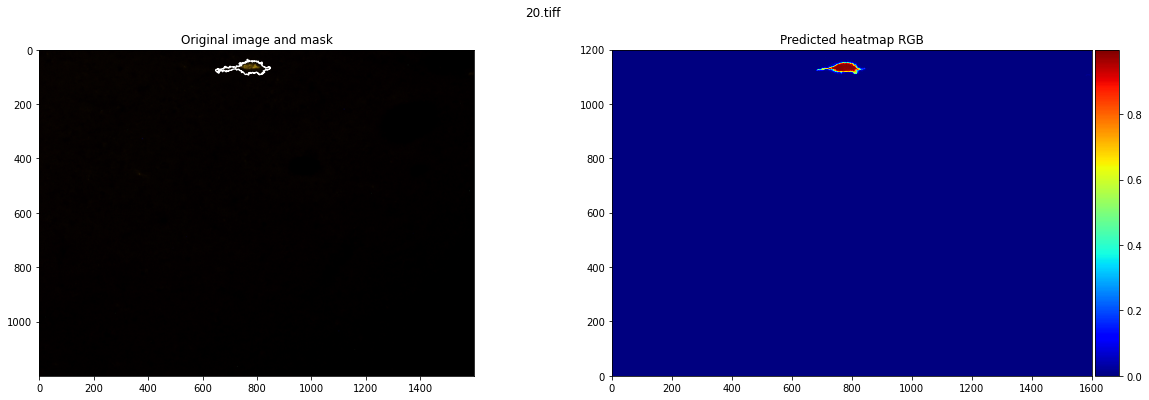

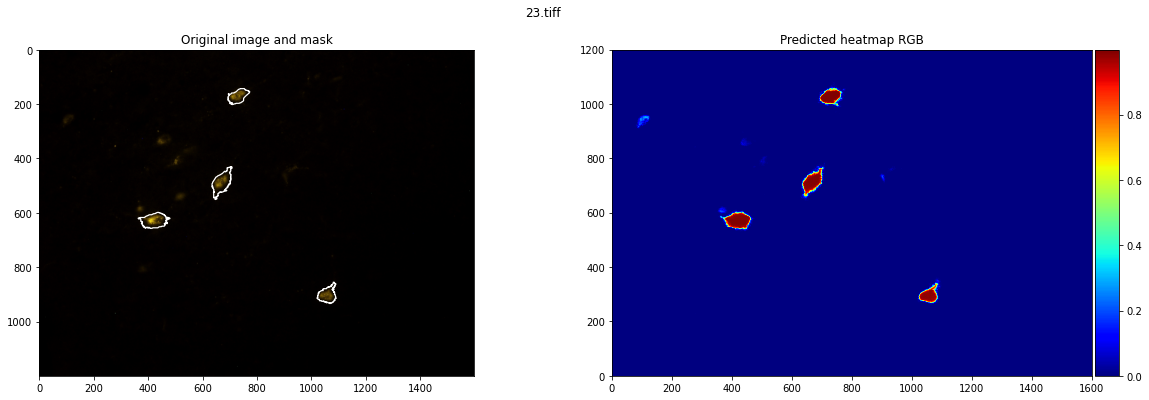

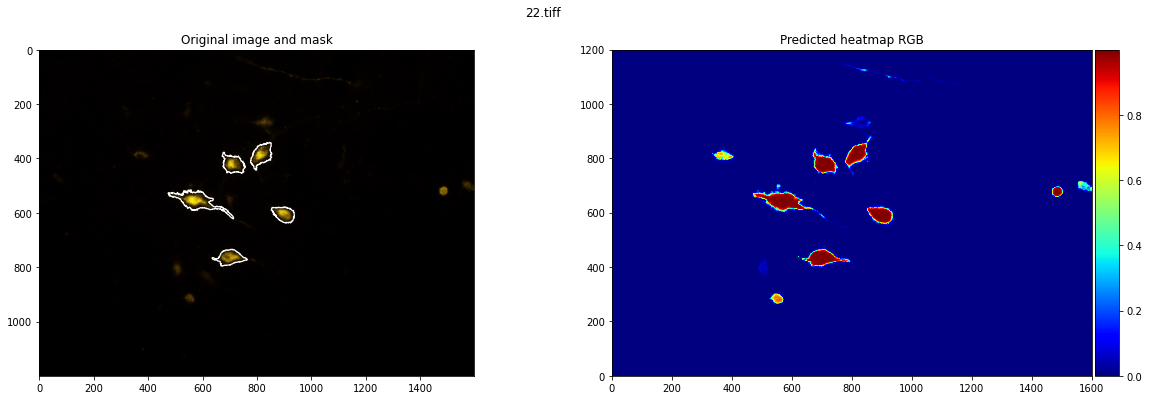

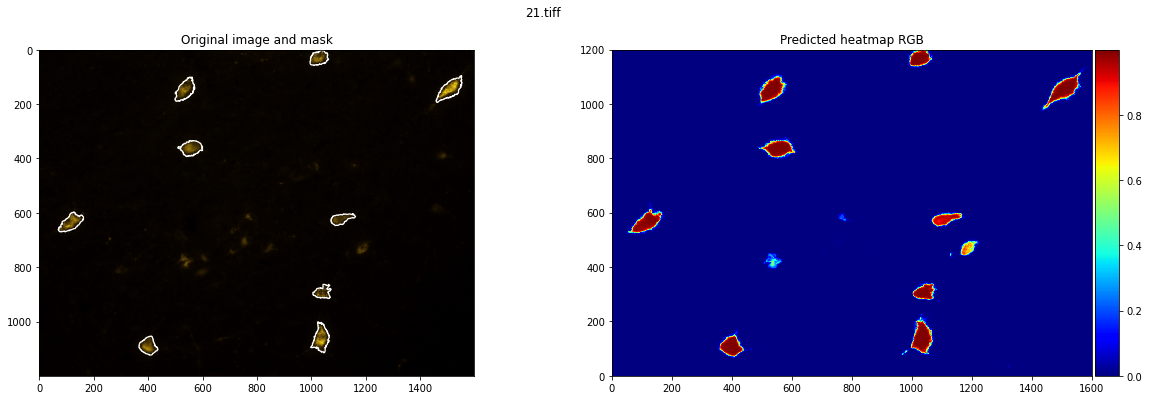

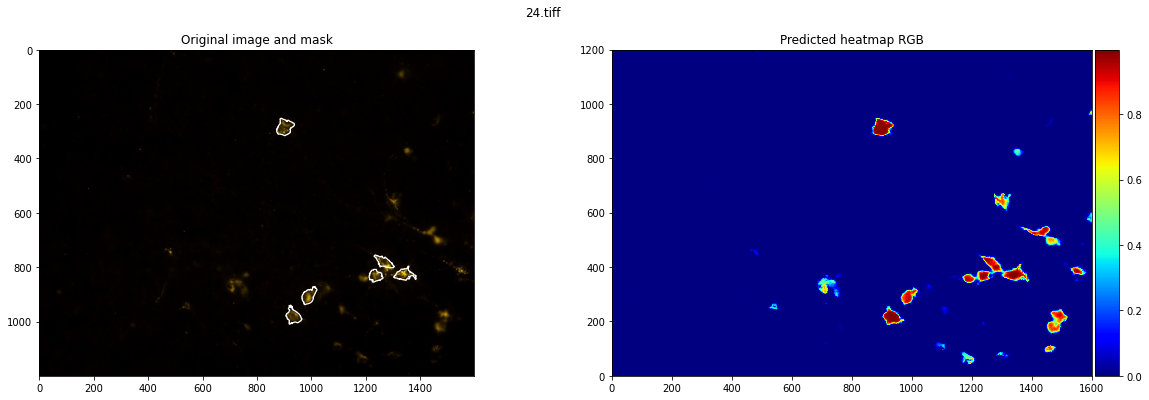

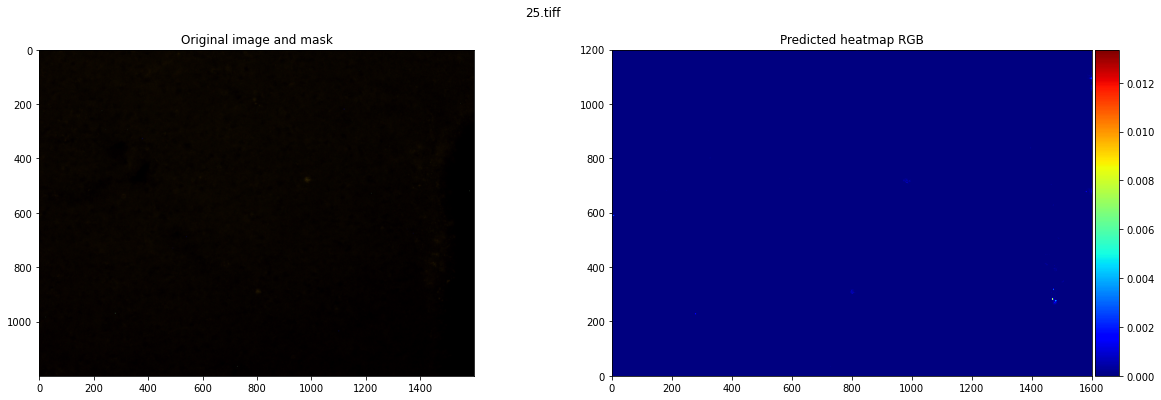

In [7]:
visualise_results.plot_predicted_heatmaps(model,SAMPLE_IMG_PATH, SAMPLE_MASKS_PATH)

The raw heatmaps suggest that the model is starting to understand *what* and *where* the cells are. However, the confidence in these predictions is very low, as we can see from the colourbar. This partly explains why the custom metrics are still bad.

# Thresholding 

Once we have the predicted heatmaps, the next step is to classify pixels into one of the two classes: signal or background.

The most immediate thing we can do is to simply thresholding the raw output of the model so to transform pixels above the cutoff into 1 (or 255 depending on the type of the image) - meaning classificationa as signal - and zero otherwise.

/home/luca/PycharmProjects/cell_counting_yellow/evaluation_utils.py:55: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  in_place=False)


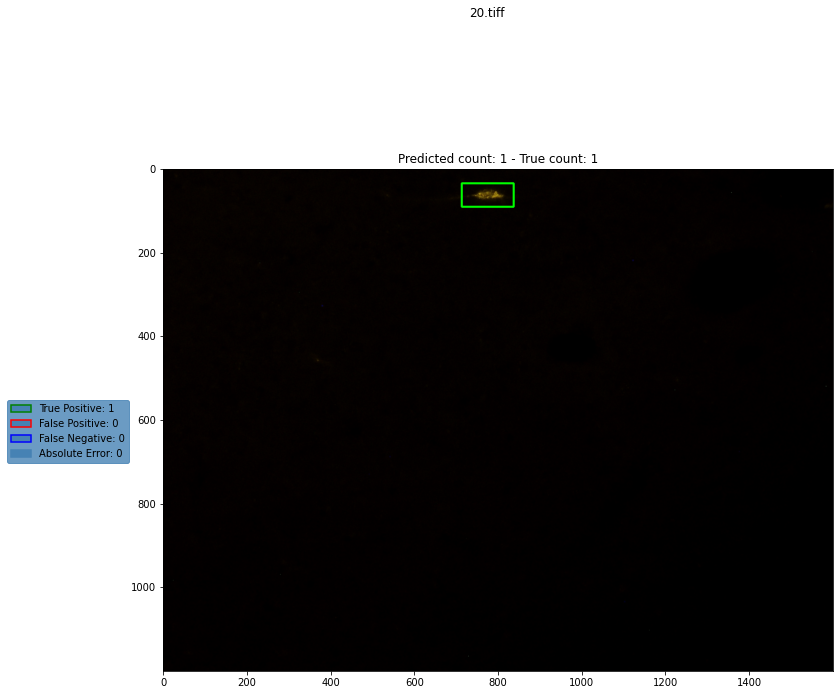

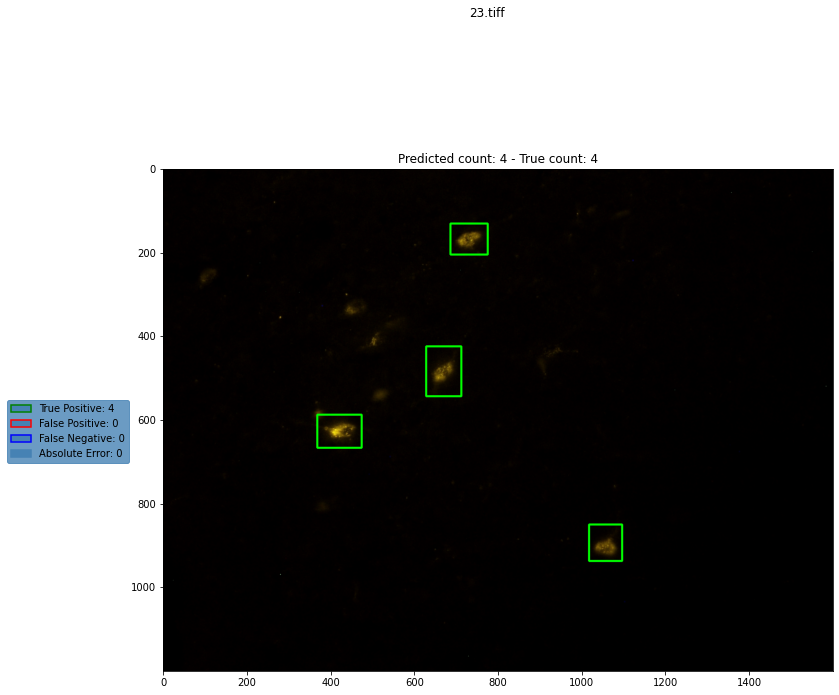

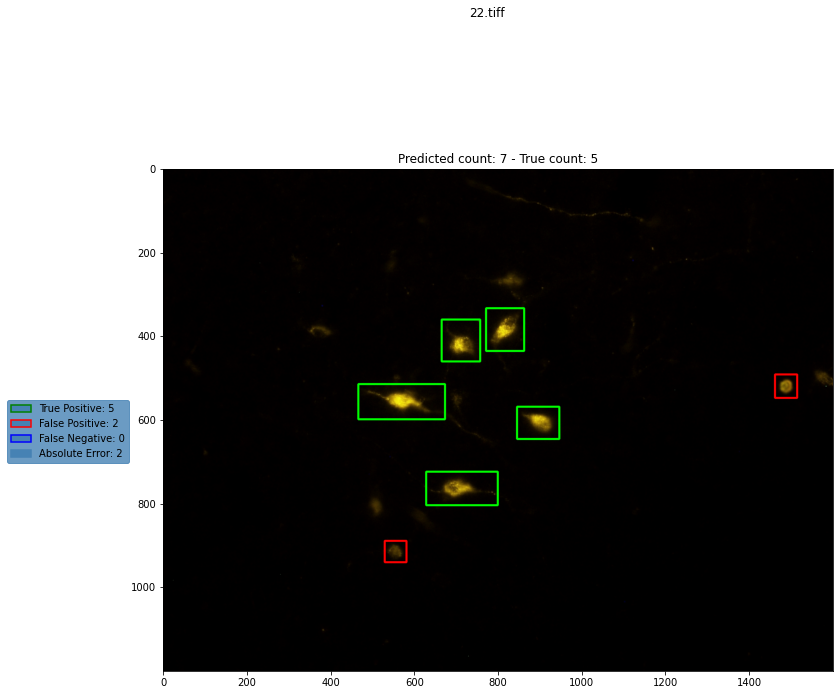

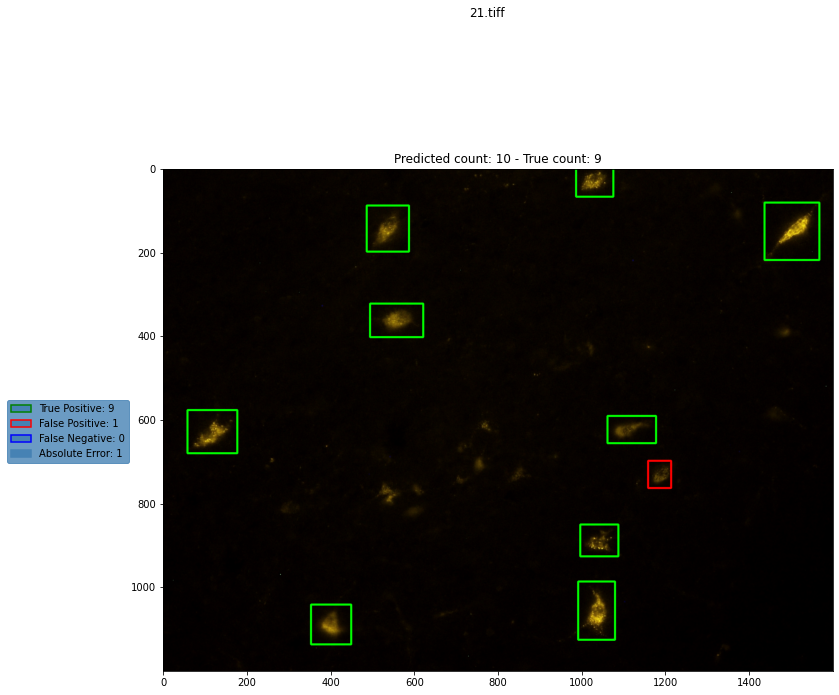

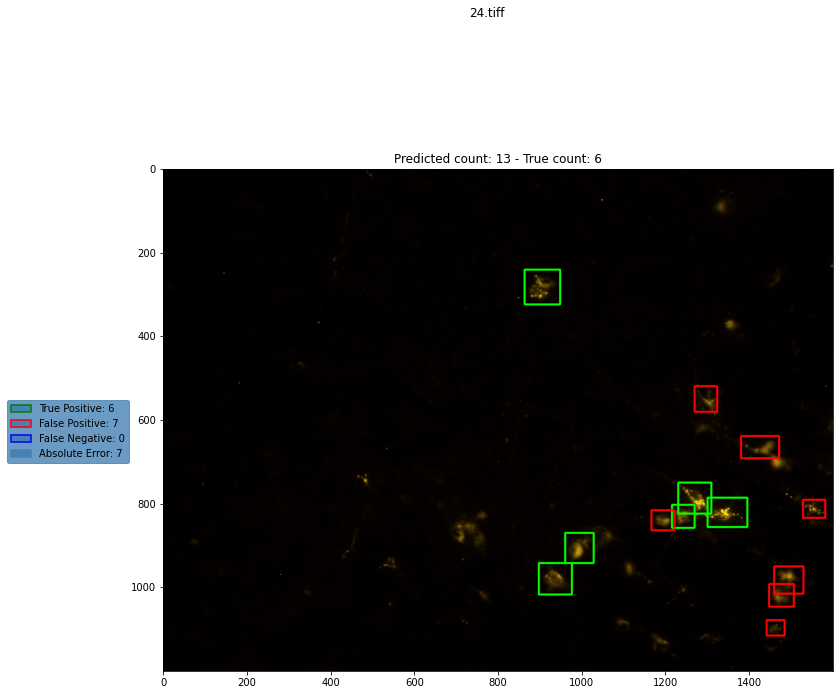

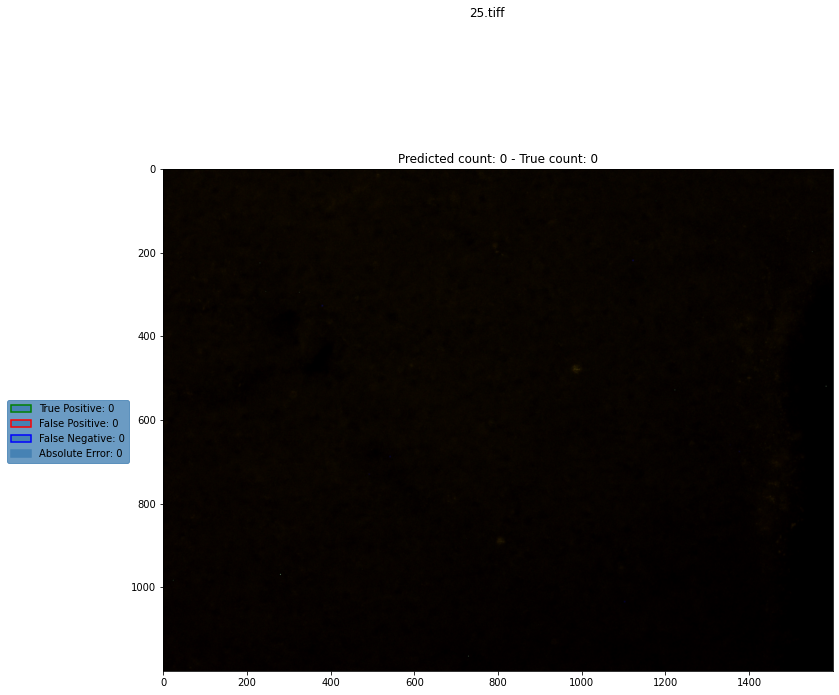

In [8]:
visualise_results.plot_predicted_mask(model,SAMPLE_IMG_PATH, SAMPLE_MASKS_PATH, threshold=0.7, post_processing=True)

As anticipated from the heatmaps, the model is starting to learn what neuronal cells are. However there is still much space for improvements, especially with objects of small size.

# Post-processing 

A more clever way to proceed is to consider some post-processing actions so to clean thresholded masks from small, spurious objects coming from isolated pixels that exceed the cutoff.

An example of such approach is shown below.

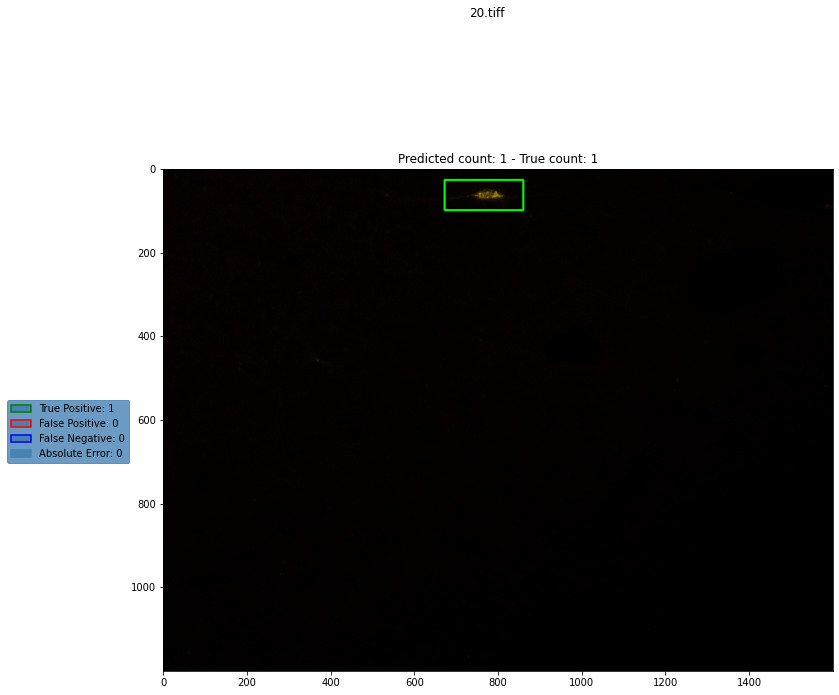

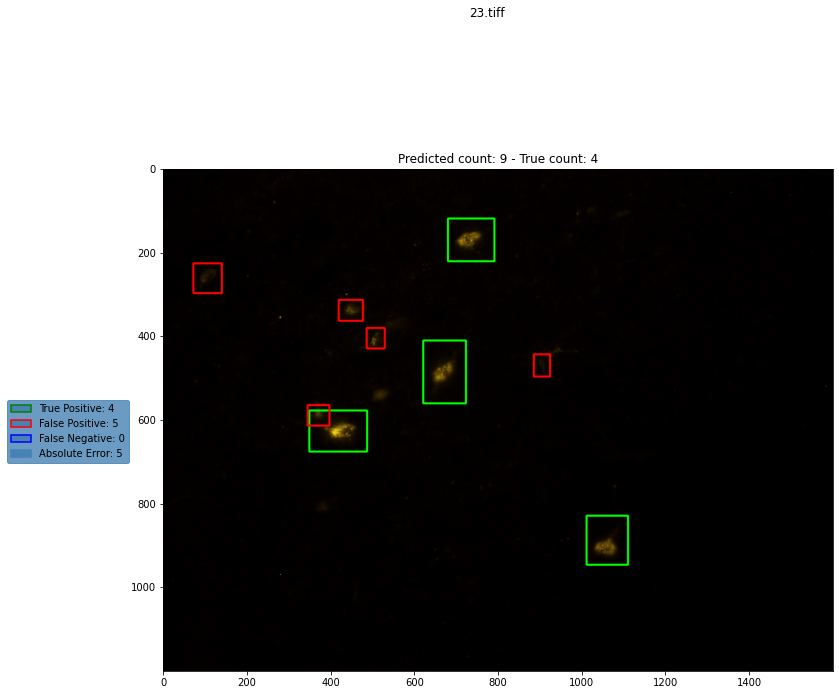

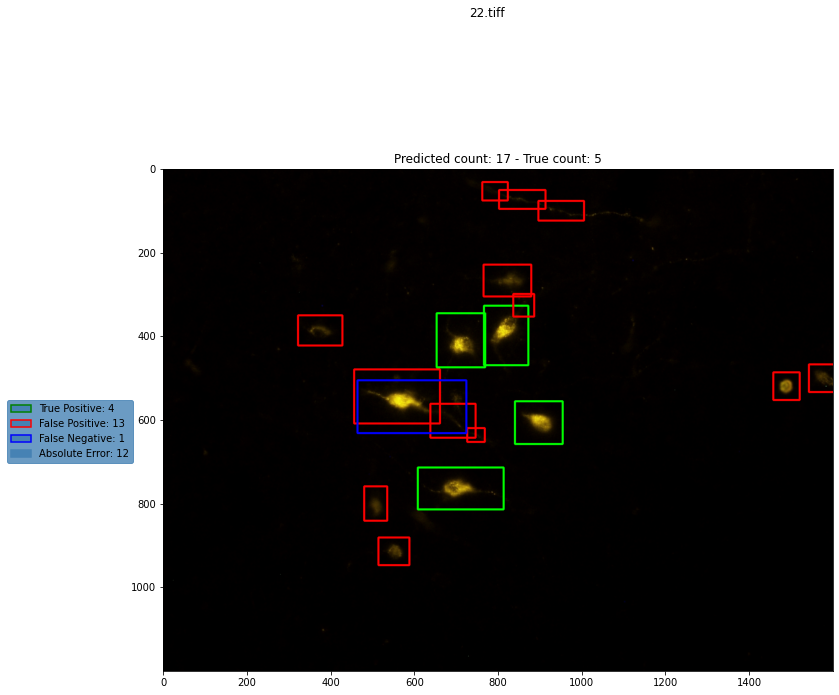

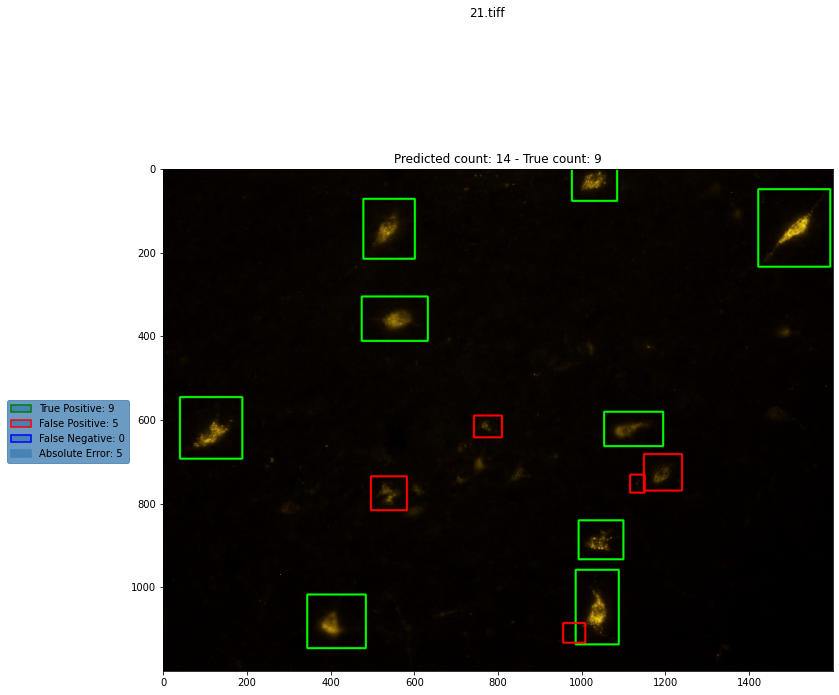

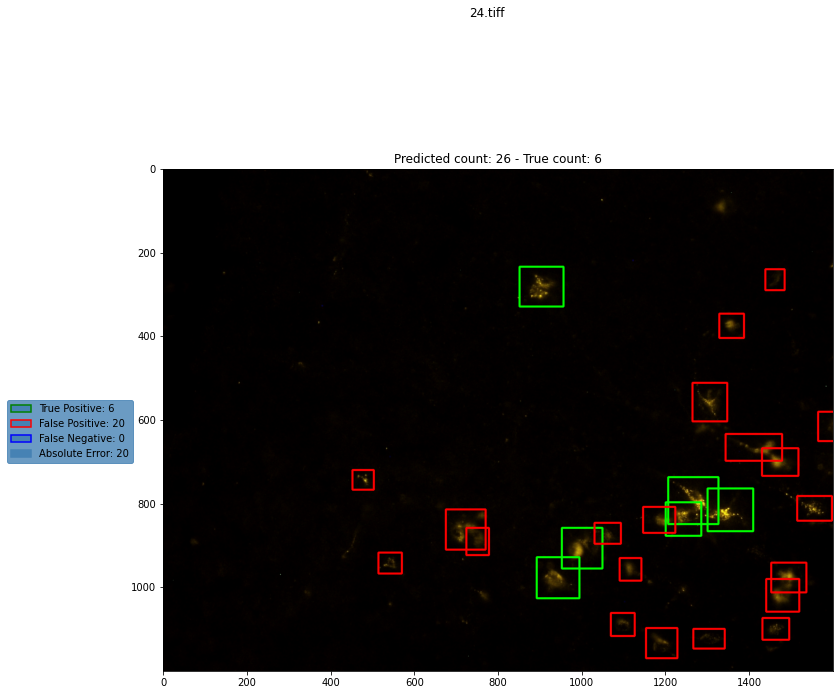

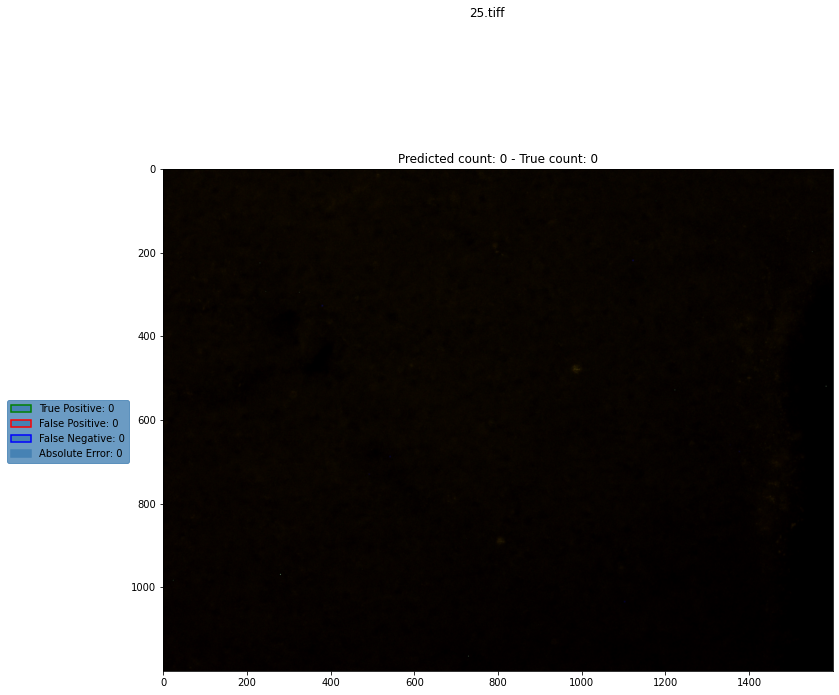

In [9]:
visualise_results.plot_predicted_mask(model,SAMPLE_IMG_PATH, SAMPLE_MASKS_PATH, threshold=0.018, post_processing=True)

The results presented above show as the post-processing is indeed effective for images where the cells are of bigger size and the model has greater confidence in prediction.

On the contrary, it seems too aggressive for pictures with small cells. Alternatively one may try to adapt the parameters of the post-processing, nonetheless the main problem in this case is that the model predictions are poor for those images. For this reason, one may want to improve the model first and then optimise the post-processing.